In [25]:
import argparse
import os
import glob
import numpy as np
import cv2
import torch
import sys
import time
import math
from pathlib import Path
from torchvision.models import DenseNet
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from pytorch_grad_cam import GradCAM
from WSI_handling import wsi
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from shapely.geometry import Polygon
# from misc_functions import get_example_params, save_class_activation_images


# from gradcam import GradCam

In [26]:
class arguments:
    def __init__(self):
#         self.model = 'pca_detect_dense_2mpp_AllCancer_bps_densenet_best_model.pth'
        self.model = 'pca_detect_dense_small_densenet_best_model.pth'
        self.batchsize = 1
        self.gpuid = 0
        self.resolution = 2
        self.annotation = 'wsi'
        self.color = 'None'
        self.biopsymodel = False
        self.colormap = False
#         self.basepath = 'TumorSegmentationTraining/UpennBiopsies'
#         self.basepath = "../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn"#'../../../../data/RTOG_0521'
        self.basepath = "../../../../data/UPenn_Prostate_Histology/UPenn_Prostate_Biopsy"
        self.input_pattern = '*.svs'
        self.force = False
        self.outdir = '../outputs_tumor_2mpp_AllCancer_bps_nopad'
#         self.outdir = '../outputs_tumor'
        self.patchsize = 224

In [28]:
args = arguments()

# ----- load network
device = torch.device(args.gpuid if torch.cuda.is_available() else 'cpu')

# %%


checkpoint = torch.load(args.model, map_location=lambda storage,
                                                        loc: storage)  # load checkpoint to CPU and then put to device https://discuss.pytorch.org/t/saving-and-loading-torch-models-on-2-machines-with-different-number-of-gpu-devices/6666
print(checkpoint["num_init_features"])
model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"],
                 drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)
model.load_state_dict(checkpoint["model_dict"])
model.eval()

# %%


print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

# %%
files = glob.glob(args.basepath + '/' + args.input_pattern)
print(files)

# grad_cam = GradCam(model, target_layer=1)
OUTPUT_DIR = args.outdir
batch_size = args.batchsize
patch_size = args.patchsize
stride_size = patch_size # //2

64
total params: 	415554
['../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/20692.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/36727.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/22977.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/38520.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/38515.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/20695.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/20702.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/22881.svs', '../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histology

In [29]:
# ------ work on files
print(model)
target_layers = [model.features[0]]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [30]:
def imfill(image):
    im_th = np.array((image > 0) * 255).astype(np.uint8).copy() 
    # Copy the thresholded image.
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    #Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out

In [31]:
# cam = GradCAM(model=model ,target_layers=target_layers, use_cuda=True) #

# for fname in files:

#     fname = fname.strip()
#     newfname_class = "%s/%s_gradcam_rp.png" % (OUTPUT_DIR, os.path.basename(fname)[0:-4])

#     print(f"working on file: \t {fname}")
#     print(f"saving to : \t {newfname_class}")

#     if not args.force and os.path.exists(newfname_class):
#         print("Skipping as output file exists")
#         continue

# #     cv2.imwrite(newfname_class, np.zeros(shape=(1, 1)))

#     img = wsi(fname)
#     img_array = img.get_wsi(desired_mpp=args.resolution)
#     h = img_array.shape[0]
#     w = img_array.shape[1]
#     slice1 = img_array[:h//2, :w//2, :]
#     slice2 = img_array[:h//2, w//2:, :]
#     slice3 = img_array[h//2:, :w//2, :]
#     slice4 = img_array[h//2:, w//2:, :]
    
#     for sl in [slice1, slice2, slice3, slice4]:
        
#         sl = sl.reshape(-1,sl.shape[0],sl.shape[1],3)

#         sl = torch.from_numpy(sl.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

#         sl = cam(input_tensor=sl,targets=None,eigen_smooth=False,aug_smooth=False)
        
#         plt.imshow(sl)
#         plt.show()

    # --- save output
    # cv2.imwrite(newfname_class, (output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)).astype(np.uint8))
#     img_array = np.uint8(cv2.normalize(img_array,  None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
#     img_array = cv2.applyColorMap(img_array, cv2.COLORMAP_HOT)
#     cv2.imwrite(newfname_class, img_array)

working on file: 	 ../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/20692.svs
saving to : 	 ../outputs_tumor/20692_gradcam_nw_rp.png


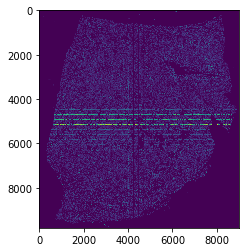

working on file: 	 ../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/36727.svs
saving to : 	 ../outputs_tumor/36727_gradcam_nw_rp.png


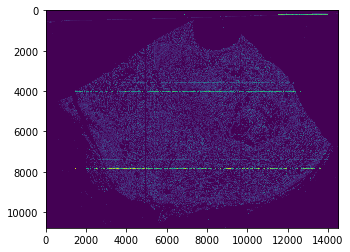

working on file: 	 ../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/22977.svs
saving to : 	 ../outputs_tumor/22977_gradcam_nw_rp.png


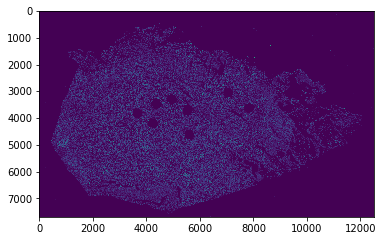

working on file: 	 ../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/38520.svs
saving to : 	 ../outputs_tumor/38520_gradcam_nw_rp.png


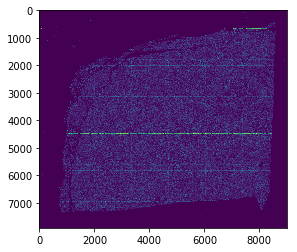

working on file: 	 ../../../../data//UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/38515.svs
saving to : 	 ../outputs_tumor/38515_gradcam_nw_rp.png


KeyboardInterrupt: 

In [32]:
cam = GradCAM(model=model ,target_layers=target_layers, use_cuda=True) #

for fname in files:

    fname = fname.strip()
    if args.biopsymodel:
        newfname_class = "%s/%s_gradcam_nw_bp.png" % (OUTPUT_DIR, os.path.basename(fname)[0:-4])
    else:
        newfname_class = "%s/%s_gradcam_nw_rp.png" % (OUTPUT_DIR, os.path.basename(fname)[0:-4])

    print(f"working on file: \t {fname}")
    print(f"saving to : \t {newfname_class}")

    if not args.force and os.path.exists(newfname_class):
        print("Skipping as output file exists")
        continue

#     cv2.imwrite(newfname_class, np.zeros(shape=(1, 1)))

    img = wsi(fname)
    w,h = img["img_dims"][0][0], img["img_dims"][0][1]
    patch_size_converted = img.get_coord_at_mpp(patch_size, input_mpp=args.resolution, output_mpp=img['mpp'])
    x_points = range(0, h, patch_size_converted)
    y_points = range(0, w, patch_size_converted)
    grid_points = [(x, y) for x in x_points for y in y_points]
    counter = 0
    output = np.zeros((0,patch_size,patch_size))
    for i, batch_points in enumerate(grid_points): 
#         print(counter + 1)
        counter += 1
        xc = batch_points[0] 
        yc = batch_points[1]
        batch_arr = img.get_tile(args.resolution, (yc, xc), (patch_size, patch_size))

        tissue_mask = ~(np.mean(batch_arr, axis = 2) > 220)

        batch_arr = batch_arr.reshape(-1,patch_size,patch_size,3)

        arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

#         # ---- get results
#         output_batch = model(arr_out_gpu)
#         cam = grad_cam.generate_cam(arr_out_gpu, 1).detach().cpu().numpy()
        graycam = cam(input_tensor=arr_out_gpu,targets=None,eigen_smooth=False,aug_smooth=False)

    # --- pull from GPU and append to rest of output 
        graycam = np.squeeze(graycam) * (tissue_mask * 1)
        graycam = np.reshape(graycam, (-1,patch_size,patch_size))

#         output[:,white_mask] = 0
#         else:        
        output = np.append(output,graycam,axis=0)

#     output = output.transpose((0, 2, 3, 1))
    #turn from a single list into a matrix of tiles
    output = output.reshape(len(x_points),len(y_points),patch_size,patch_size)
    
    #turn all the tiles into an image
    output=np.concatenate(np.concatenate(output,1),1)

    #incase there was extra padding to get a multiple of patch size, remove that as well
    new_h = img.get_coord_at_mpp(h, input_mpp=img['mpp'], output_mpp=args.resolution)
    new_w = img.get_coord_at_mpp(w, input_mpp=img['mpp'], output_mpp=args.resolution)
    output = output[0:new_h, 0:new_w] #remove paddind, crop back
    
    plt.imshow(output)
    plt.show()
    # --- save output
    # cv2.imwrite(newfname_class, (output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)).astype(np.uint8))
    if args.biopsymodel:
        output = np.uint8(cv2.normalize(output,  None, 0, 255, cv2.NORM_MINMAX))
    else:
        output = np.uint8(cv2.normalize(output,  None, 0, 255, cv2.NORM_MINMAX))
    if args.colormap:
        output = cv2.applyColorMap(output, cv2.COLORMAP_HOT)
    cv2.imwrite(newfname_class, output)

In [ ]:
print(output.shape)